# Avaliação - Regressão
## Inferir custos médicos do plano de saúde a partir do arquivo insurance.csv

### Carregamento dos dados

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot

In [2]:
insurance = pd.read_csv(Path('insurance.csv'))
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Visualizando os dados

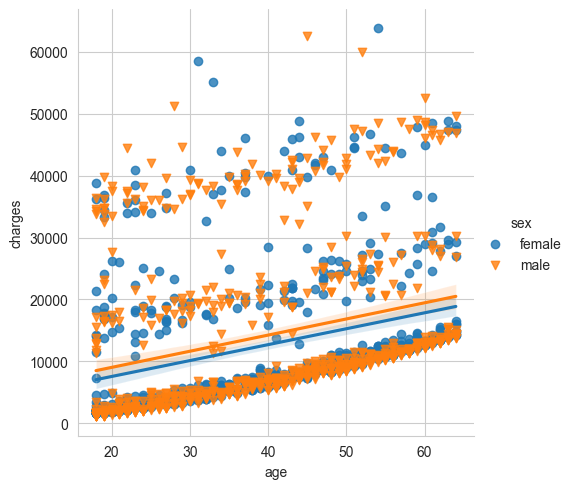

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set_style('whitegrid')
sns.lmplot(x ='age', y ='charges', data = insurance, hue ='sex', markers =['o', 'v'])

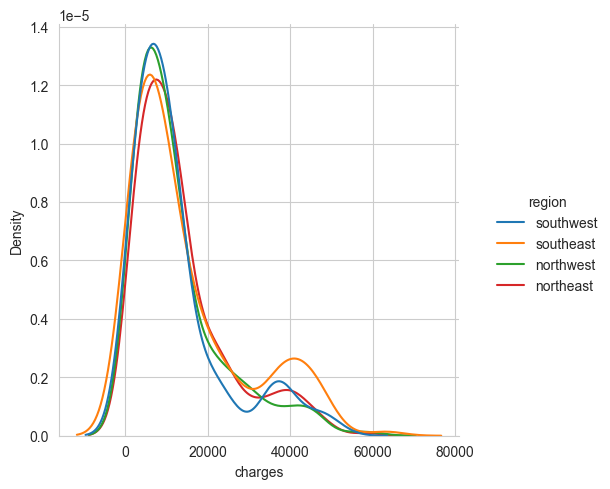

In [5]:
sns.displot(x='charges', data=insurance, hue='region', kind='kde')

<AxesSubplot:xlabel='age', ylabel='Count'>

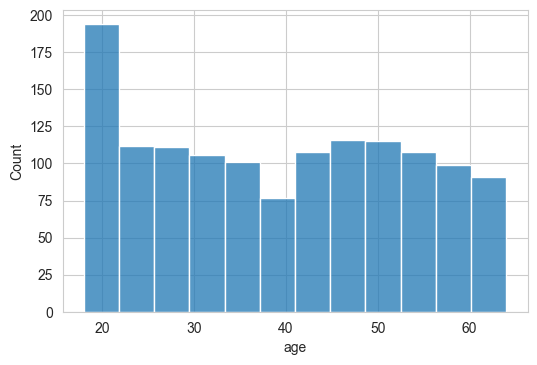

In [6]:
sns.histplot(insurance['age'])

<AxesSubplot:xlabel='sex', ylabel='Count'>

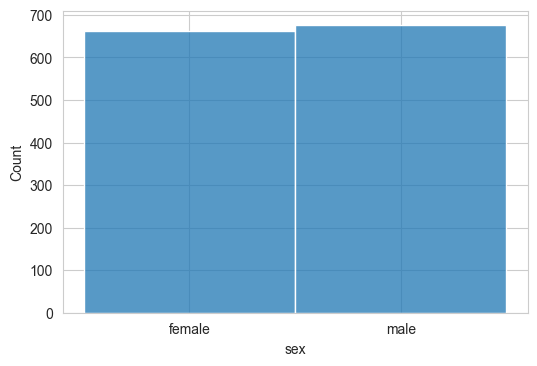

In [7]:
sns.histplot(insurance['sex'])

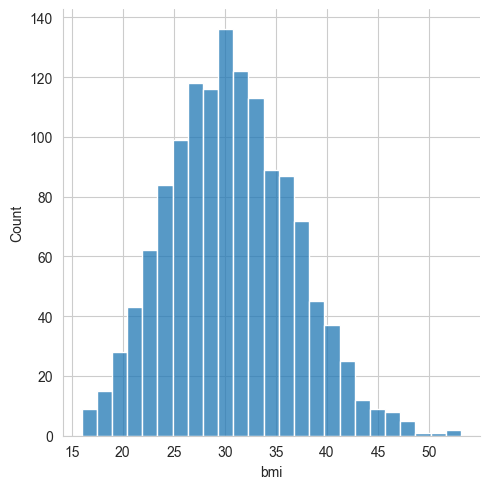

In [8]:
sns.displot(insurance['bmi'])

<AxesSubplot:xlabel='children', ylabel='Count'>

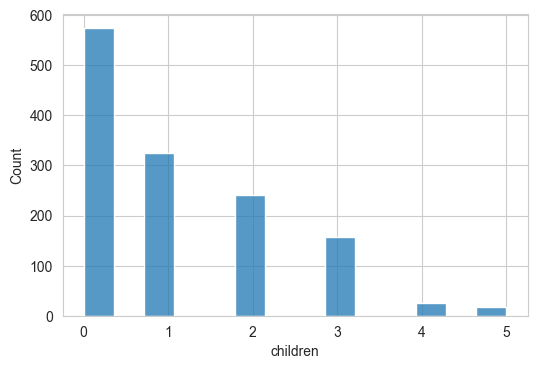

In [9]:
sns.histplot(insurance['children'])

<AxesSubplot:xlabel='smoker', ylabel='Count'>

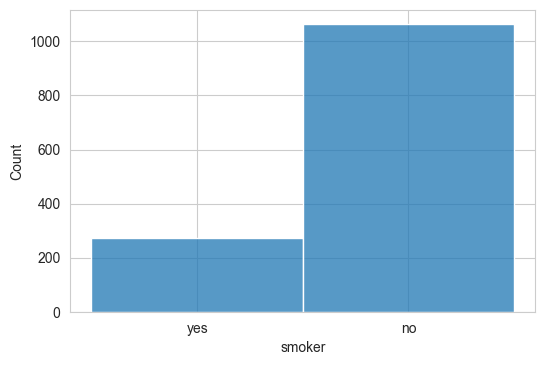

In [10]:
sns.histplot(insurance['smoker'])

<AxesSubplot:xlabel='region', ylabel='Count'>

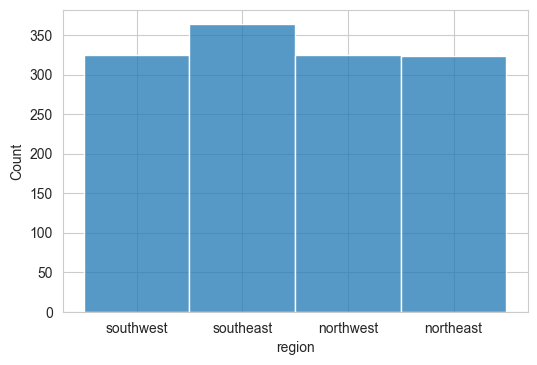

In [11]:
sns.histplot(insurance['region'])

In [12]:
#normalizar os valores, por exemplo min-max (0-1) para tirar os valores negativos
#transformer = MaxAbsScaler().fit(insurance['charges'].values.reshape(-1,1))
#transformer = transformer.transform(insurance['charges'].values.reshape(-1,1))
#insurance['charges'] = transformer.reshape(-1)
#sns.displot(insurance['charges'], kind = 'kde')

### Preparação dos dados

In [13]:
#função para reverter o pandas.get_dummies()
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [14]:
one_hot_encoding = pd.get_dummies(insurance[['sex', 'region', 'smoker']])
one_hot_encoding.head()

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,1,0,0,0,0,1,0,1
1,0,1,0,0,1,0,1,0
2,0,1,0,0,1,0,1,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,0,0,1,0


In [15]:
insurance = insurance.drop(['sex', 'region', 'smoker'], axis = 1)

In [16]:
insurance = pd.concat([insurance, one_hot_encoding], axis=1)
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   region_northeast  1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
 10  smoker_no         1338 non-null   uint8  
 11  smoker_yes        1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


In [17]:
insurance.corr()['charges'].sort_values()

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

In [18]:
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

1070 train + 268 test


In [19]:
y_train, y_test = train_set['charges'], test_set['charges']

In [20]:
x_train, x_test = train_set.drop(['charges'], axis=1), test_set.drop(['charges'], axis=1)
x_train.head()

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
560,46,19.95,2,1,0,0,1,0,0,1,0
1285,47,24.32,0,1,0,1,0,0,0,1,0
1142,52,24.86,0,1,0,0,0,1,0,1,0
969,39,34.32,5,1,0,0,0,1,0,1,0
486,54,21.47,3,1,0,0,1,0,0,1,0


### Treinamento e avaliação

### Método dos Mínimos Quadrados

In [21]:
lin_reg = LinearRegression() 
lin_reg.fit(x_train,y_train)
resultado=lin_reg.predict(x_test)

In [22]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado))

33596915.851361476


In [23]:
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado))

4181.1944737536505


In [24]:
#o melhor valor é 1.0
print(r2_score(y_test, resultado))

0.7835929767120722


In [25]:
print(f'Valor mínimo: {min(y_train)}')
print(f'Valor máximo: {max(y_train)}')
print(f'Média: {np.mean(y_train)}')

Valor mínimo: 1121.8739
Valor máximo: 62592.87309
Média: 13346.089736364485


In [26]:
print(f'Valor mínimo: {min(resultado)}')
print(f'Valor máximo: {max(resultado)}')
print(f'Média: {np.mean(resultado)}')
print(f'Intercept: {lin_reg.intercept_}')

Valor mínimo: -1545.5718493380846
Valor máximo: 40920.29151164597
Média: 13187.557732494492
Intercept: -574.5357125102091


In [27]:
lin_reg.coef_

array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02,  9.29584582e+00,
       -9.29584582e+00,  4.59585244e+02,  8.89079180e+01, -1.98279052e+02,
       -3.50214110e+02, -1.18255644e+04,  1.18255644e+04])

<AxesSubplot:xlabel='sex_female', ylabel='Count'>

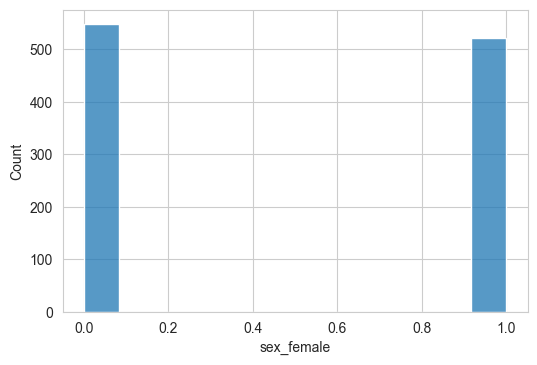

In [28]:
#fazer histograma dos atributos mais e menos importantes, respectivamente
sns.histplot(x_train['sex_female'])

<AxesSubplot:xlabel='smoker_yes', ylabel='Count'>

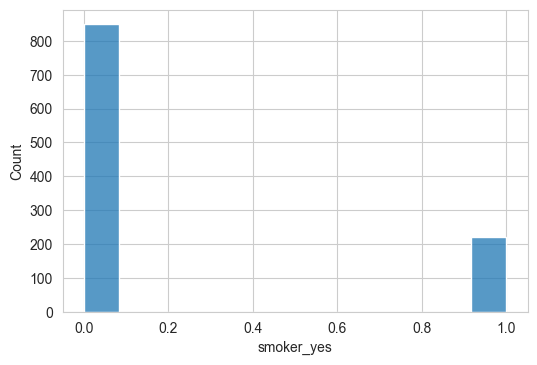

In [29]:
sns.histplot(x_train['smoker_yes'])

In [30]:
def cria_label(valor):
    if valor <= 10000:
        return '$0-10,000'
    elif valor in range(10001,20001):
        return '$10,001-20,000'
    elif valor in range(20001,30001):
        return '$20,001-30,000'
    elif valor in range(30001,40001):
        return '$30,001-40,000'
    elif valor in range(40001,50001):
        return '$40,001-50,000'
    elif valor in range(50001,60001):
        return '$50,001-60,000'
    else:
        return '$60,001+'

insurance['charges'] = [round(x) for x in insurance['charges']]
for index in range(0, len(insurance)):
    insurance.at[index, 'labels'] = cria_label(insurance.at[index, 'charges'])

In [31]:
insurance['labels'].value_counts()

$0-10,000         712
$10,001-20,000    353
$20,001-30,000    111
$30,001-40,000     83
$40,001-50,000     72
$50,001-60,000      4
$60,001+            3
Name: labels, dtype: int64

In [32]:
#Gráfico de cluster com rótulos - UMPA

#mapper = umap.UMAP().fit(insurance['charges'].values.reshape(-1,1))
#sent_labels = insurance['labels']
#sent_labels.value_counts()
#umap.plot.points(mapper, labels=sent_labels)

In [33]:
#Gráfico de cluster sem rótulos - UMPA

#umap_embedder = umap.UMAP()
#umap_features = umap_embedder.fit_transform(insurance['charges'].values.reshape(-1,1))

# Choose number of clusters and colormap
#n_clusters=7
#cmap = plt.get_cmap("Set2")
#fig = plt.figure(figsize=(7, 7))


# Fit clustering algorithm to our vectorized features
#clus = KMeans(n_clusters=n_clusters, random_state=10)
#clusters = clus.fit_predict(insurance['charges'].values.reshape(-1,1))

# Plot the dimentionality reduced features on a 2D plane
#plt.scatter(umap_features[:, 0], umap_features[:, 1], 
#            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
#plt.title('UMAP projection of questions, colored by clusters', fontsize=7);

### Gradiente Descendente

In [34]:
#sgd_reg = SGDRegressor(verbose=True, n_iter_no_change=10, shuffle=True, max_iter=100000)
sgd_reg = SGDRegressor(verbose=True, n_iter_no_change=40, shuffle=True, max_iter=5000, random_state=42, alpha=0.1)
sgd_reg.fit(x_train,y_train)
resultado_sgd=sgd_reg.predict(x_test)

-- Epoch 1
Norm: 77796916052.25, NNZs: 11, Bias: -4226789205.328780, T: 1070, Avg. loss: 6418158086325468567437312.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 74741156253.07, NNZs: 11, Bias: -12248521959.139065, T: 2140, Avg. loss: 2415407421399580373155840.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 25431876367.61, NNZs: 11, Bias: -4230253296.433906, T: 3210, Avg. loss: 1638577102591788188696576.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 63491565611.06, NNZs: 11, Bias: -2656943614.403741, T: 4280, Avg. loss: 1384345719852316122677248.000000
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 44833555812.20, NNZs: 11, Bias: 4563229591.600128, T: 5350, Avg. loss: 1098854435702697197830144.000000
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 45204648143.13, NNZs: 11, Bias: 13468326346.546320, T: 6420, Avg. loss: 900088379795269318868992.000000
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 48564863163.78, NNZs: 11, Bias: 1208746411

In [35]:
print(f'Valor mínimo: {min(resultado_sgd)}')
print(f'Valor máximo: {max(resultado_sgd)}')
print(f'Média: {np.mean(resultado_sgd)}')
print(f'Intercept: {sgd_reg.intercept_}')

Valor mínimo: -712.8379339409375
Valor máximo: 41152.26532130575
Média: 14952.835510132043
Intercept: [-8053.47857169]


In [36]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado_sgd))

47435278.07478512


In [37]:
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado_sgd))

5802.01113104671


In [38]:
#o melhor valor é 1.0
print(r2_score(y_test, resultado_sgd))

0.694456259841977


### Polinomial Features

In [39]:
from sklearn.preprocessing import PolynomialFeatures
pol_features = PolynomialFeatures(degree=2, include_bias=False)
X_pol = pol_features.fit_transform(x_train)


In [40]:
X_pol[0]

array([4.600000e+01, 1.995000e+01, 2.000000e+00, 1.000000e+00,
       0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
       0.000000e+00, 1.000000e+00, 0.000000e+00, 2.116000e+03,
       9.177000e+02, 9.200000e+01, 4.600000e+01, 0.000000e+00,
       0.000000e+00, 4.600000e+01, 0.000000e+00, 0.000000e+00,
       4.600000e+01, 0.000000e+00, 3.980025e+02, 3.990000e+01,
       1.995000e+01, 0.000000e+00, 0.000000e+00, 1.995000e+01,
       0.000000e+00, 0.000000e+00, 1.995000e+01, 0.000000e+00,
       4.000000e+00, 2.000000e+00, 0.000000e+00, 0.000000e+00,
       2.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
       0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 1.000000e+00, 0.0000

In [41]:
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_pol, y_train)
lin_reg_poly.intercept_, lin_reg_poly.coef_

(-13917.48175926089,
 array([-2.84732561e+01,  5.15505568e+02,  3.59267527e+02,  2.55646388e+02,
        -2.55646388e+02, -2.89060355e+01, -3.99422891e+02,  3.42838566e+02,
         8.54903605e+01,  3.80409587e+03, -3.80409587e+03,  3.96958227e+00,
         5.82334116e-01, -7.24743992e+00, -2.30677757e+01, -5.40548039e+00,
        -4.10391878e+01, -1.64986273e+01,  9.04658405e+00,  2.00179750e+01,
        -1.61116610e+01, -1.23615951e+01, -7.02876215e+00,  8.39317794e+00,
         2.49043142e+02,  2.66462426e+02,  1.90701362e+02,  1.63363353e+02,
         6.75714006e+01,  9.38694524e+01, -4.79928310e+02,  9.95433878e+02,
        -8.36247027e+01,  3.03453576e+02,  5.58139514e+01,  3.45625192e+02,
         3.50744093e+02, -5.99367780e+01, -2.77164980e+02,  4.02982175e+02,
        -4.37146483e+01,  2.55646388e+02,  0.00000000e+00,  4.80642944e+02,
        -3.43866503e+02, -8.89314966e+01,  2.07801444e+02,  2.09420549e+03,
        -1.83855910e+03, -2.55646388e+02, -5.09548979e+02, -5.55563

In [42]:
#Testando o polynomial features
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
("lin_reg", LinearRegression()),
], verbose=True)

In [43]:
polynomial_regression.fit(x_train, y_train)
resultado_poly = polynomial_regression.predict(x_test)

[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing lin_reg, total=   0.0s


In [44]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado_poly))

20712805.987918198


In [45]:
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado_poly))

2729.5001336393625


In [46]:
#o melhor valor é 1.0
print(r2_score(y_test, resultado_poly))

0.8665830903164851


In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Create linear regression object
poly = PolynomialFeatures(degree=2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = linear_model.LinearRegression()
model.fit(x_train_poly, y_train)

print(model.score(x_train_poly, y_train))

0.8403111432471425


In [48]:
resultado_poly_teste = model.predict(x_test_poly)

In [49]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado_poly_teste))
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado_poly_teste))
#o melhor valor é 1.0
print(r2_score(y_test, resultado_poly_teste))

21006099.97711586
2696.6380577854475
0.8646939026472564


### Regularização

In [50]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(x_train, y_train)
resultado_ridge = ridge_reg.predict(x_test)

In [51]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x_train, y_train)
resultado_lasso = lasso_reg.predict(x_test)

In [52]:
#l1_ratio define o nível de mixagem entre a Ridge Regression e Lasso Regression
#l1_ratio = 0 é equivalente ao Ridge Regression e l1_ratio = 1 é equivalente ao Lasso Regression
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x_train, y_train)
resultado_elastic = elastic_net.predict(x_test)

In [53]:
print('MSE, MAE E R2 SEM REGULARIZAÇÃO')
print(mean_squared_error(y_test, resultado))
print(mean_absolute_error(y_test, resultado))
print(r2_score(y_test, resultado))

MSE, MAE E R2 SEM REGULARIZAÇÃO
33596915.851361476
4181.1944737536505
0.7835929767120722


In [54]:
print('MSE, MAE E R2 COM REGULARIZAÇÃO RIDGE')
print(mean_squared_error(y_test, resultado_ridge))
print(mean_absolute_error(y_test, resultado_ridge))
print(r2_score(y_test, resultado_ridge))

MSE, MAE E R2 COM REGULARIZAÇÃO RIDGE
33599158.94621082
4181.804730676914
0.7835785283180159


In [55]:
print('MSE, MAE E R2 COM REGULARIZAÇÃO LASSO')
print(mean_squared_error(y_test, resultado_lasso))
print(mean_absolute_error(y_test, resultado_lasso))
print(r2_score(y_test, resultado_lasso))

MSE, MAE E R2 COM REGULARIZAÇÃO LASSO
33597188.764974795
4181.251200608466
0.7835912188000385


In [56]:
print('MSE, MAE E R2 COM REGULARIZAÇÃO ELASTICNET MEIO TERMO')
print(mean_squared_error(y_test, resultado_elastic))
print(mean_absolute_error(y_test, resultado_elastic))
print(r2_score(y_test, resultado_elastic))

MSE, MAE E R2 COM REGULARIZAÇÃO ELASTICNET MEIO TERMO
36213760.61461093
4497.633170480235
0.7667371561323844


### Curvas de aprendizado

In [57]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.xlabel("Número de instâncias de treinamento")
    plt.ylabel("RMSE")
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Conjunto de treinamento")  
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="Conjunto de validação")
    plt.legend()

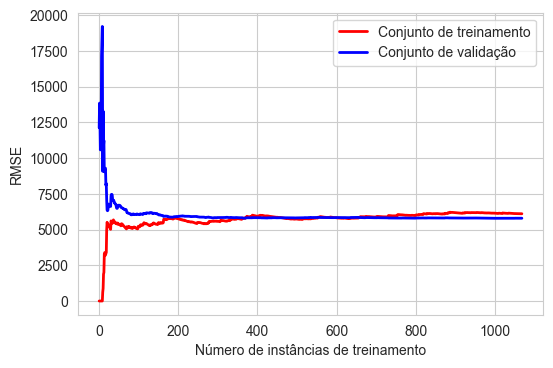

In [58]:
curva_lin_reg = LinearRegression()
plot_learning_curves(curva_lin_reg, pd.concat([x_train, x_test]), pd.concat([y_train, y_test]))

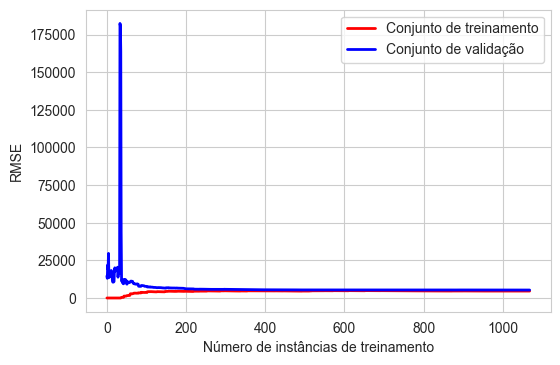

In [59]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, pd.concat([x_train, x_test]), pd.concat([y_train, y_test]))

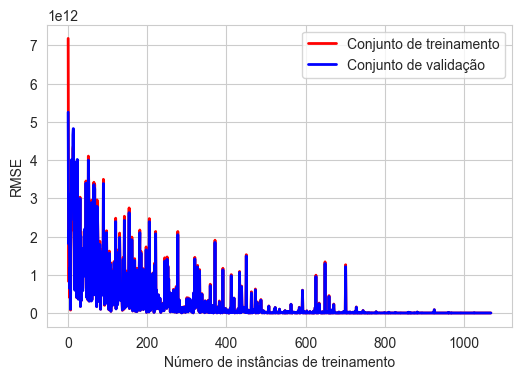

In [60]:
curva_lin_reg = SGDRegressor(n_iter_no_change=10, shuffle=True, max_iter=5000, random_state=42, alpha=0.1)
plot_learning_curves(curva_lin_reg, pd.concat([x_train, x_test]), pd.concat([y_train, y_test]))

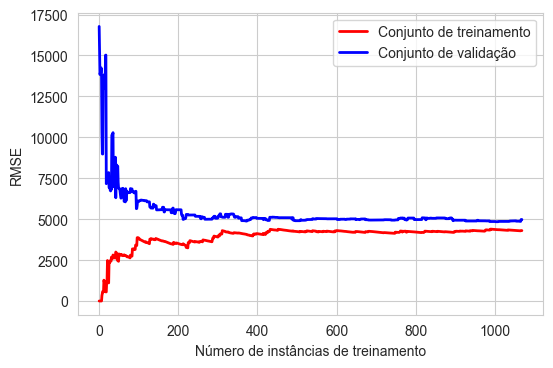

In [61]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42, max_depth=4)
plot_learning_curves(regressor, pd.concat([x_train, x_test]), pd.concat([y_train, y_test]))

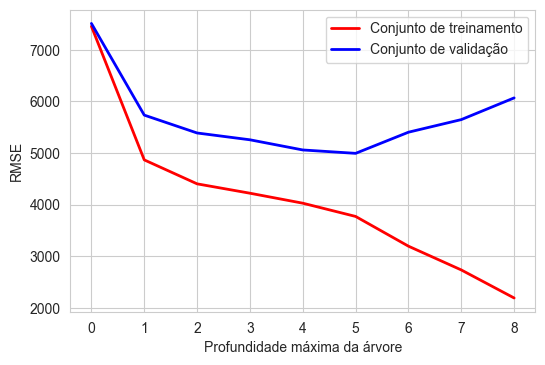

In [62]:
def plot_learning_curves_tree(X, y, max_depth):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for max in range(1, max_depth):
        model = DecisionTreeRegressor(random_state=42, max_depth=max)
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.xlabel("Profundidade máxima da árvore")
    plt.ylabel("RMSE")
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Conjunto de treinamento")  
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="Conjunto de validação")
    plt.legend()

plot_learning_curves_tree(pd.concat([x_train, x_test]), pd.concat([y_train, y_test]), 10)

### Árvore de Regressão

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
regressor = DecisionTreeRegressor(random_state=42, max_depth=4)
regressor.fit(x_train, y_train)
resultado_arvore = regressor.predict(x_test)

In [64]:
print('MSE, MAE E R2 COM ÁRVORE DE REGRESSÃO')
print(mean_squared_error(y_test, resultado_arvore))
print(mean_absolute_error(y_test, resultado_arvore))
print(r2_score(y_test, resultado_arvore))

MSE, MAE E R2 COM ÁRVORE DE REGRESSÃO
21093484.004597444
2697.765430538481
0.8641310379678357


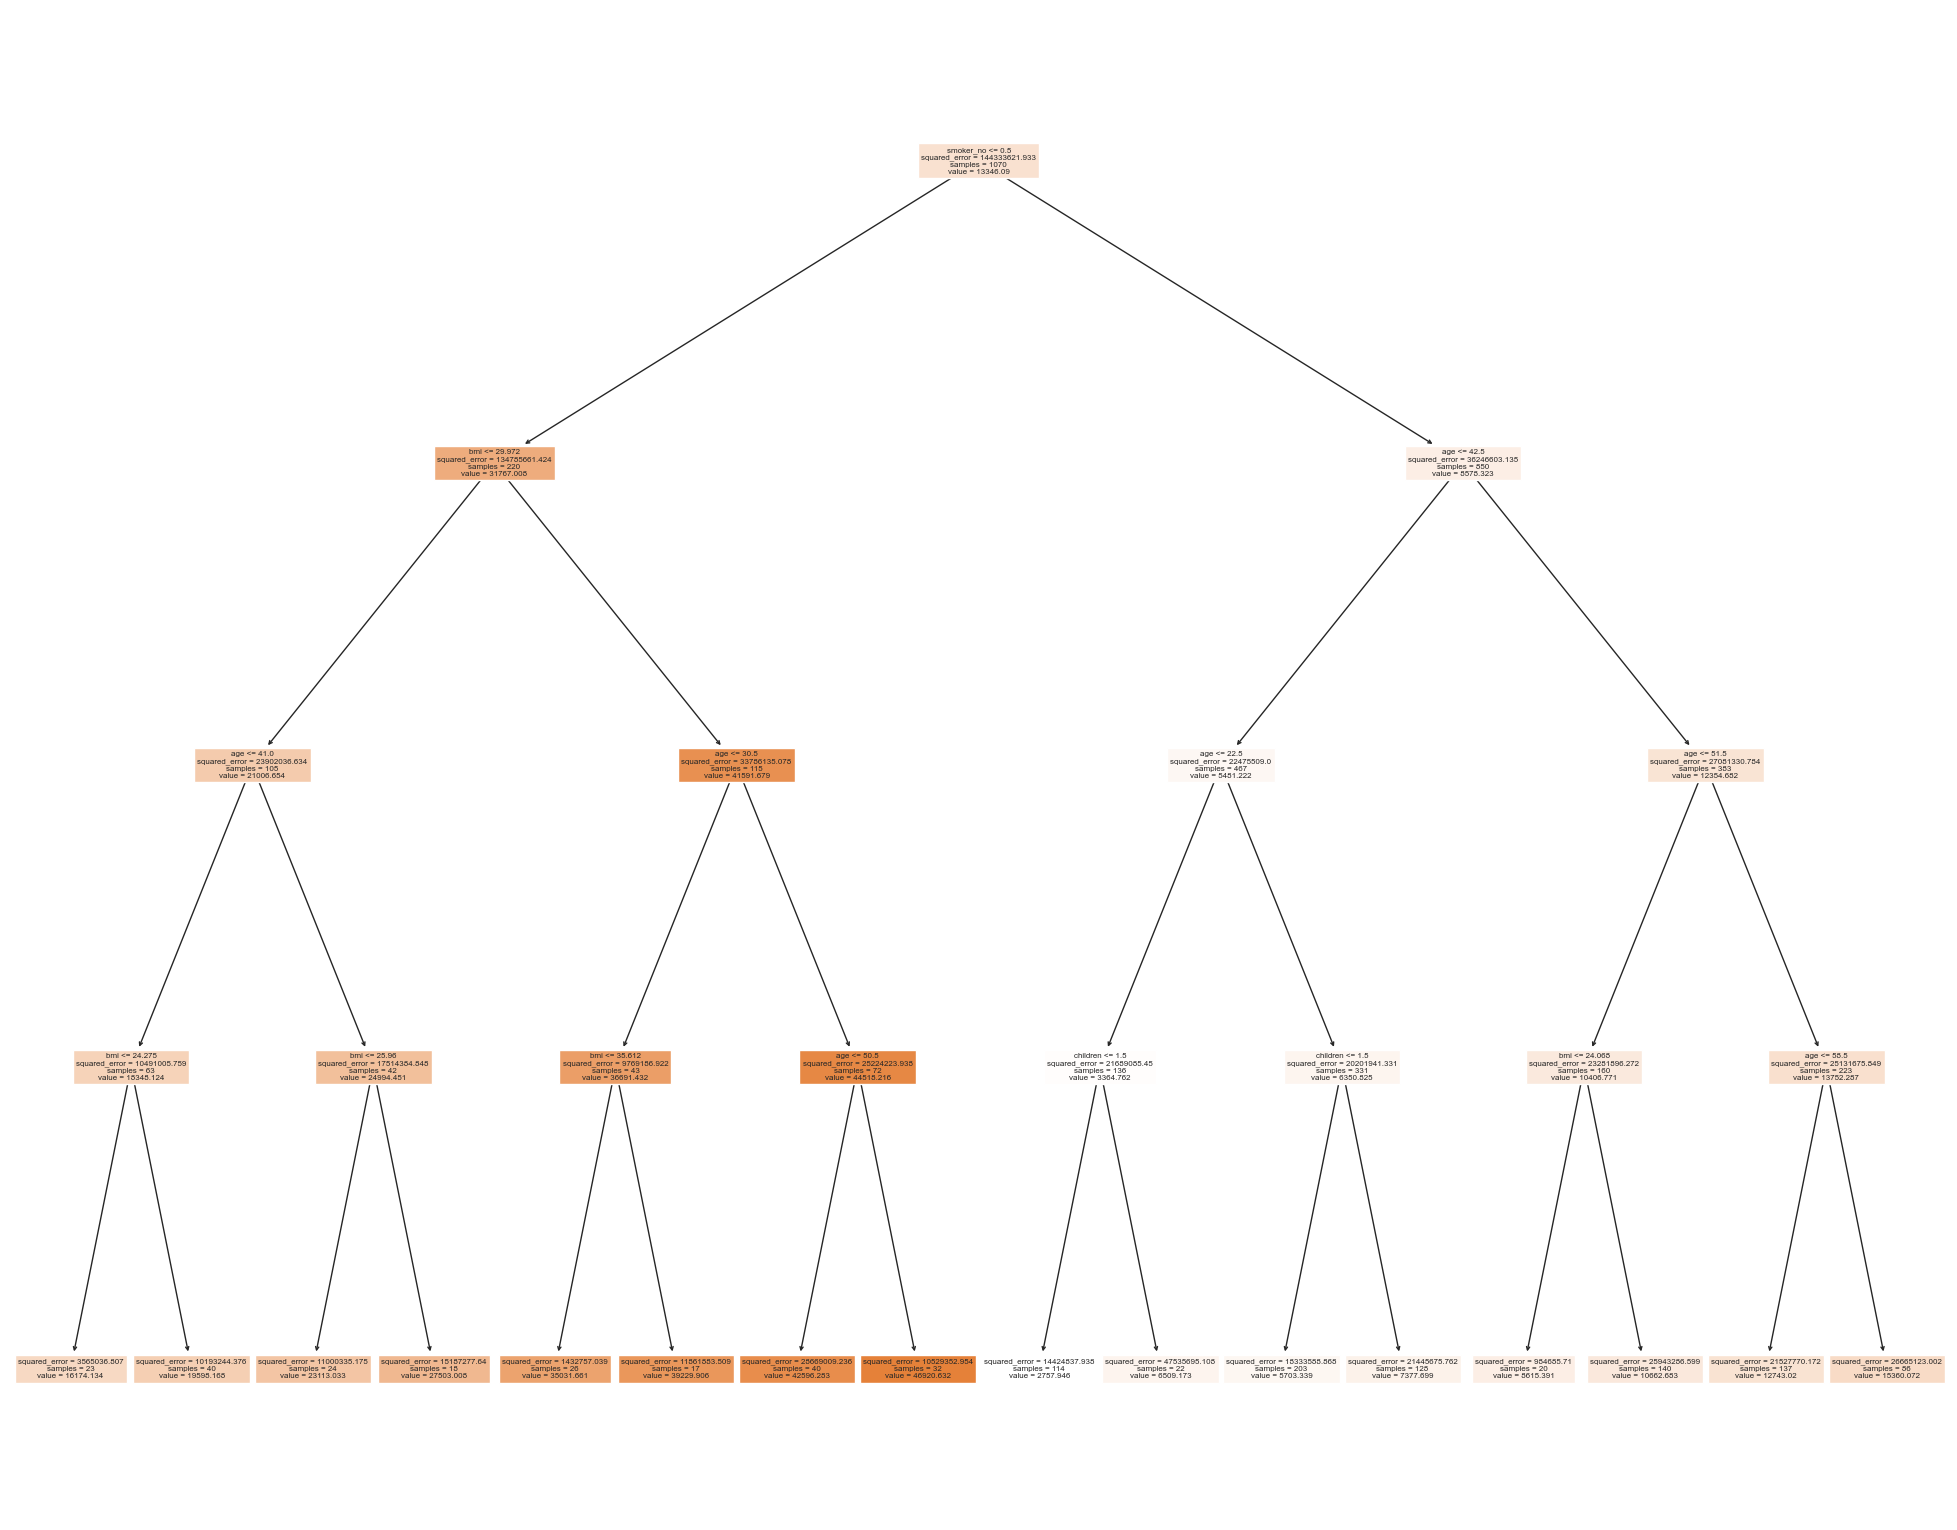

In [65]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(regressor, feature_names=x_train.columns, filled=True)

In [66]:
fig.savefig('decision_tree.pdf')

c:\users\pc gamer\appdata\local\programs\python\python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


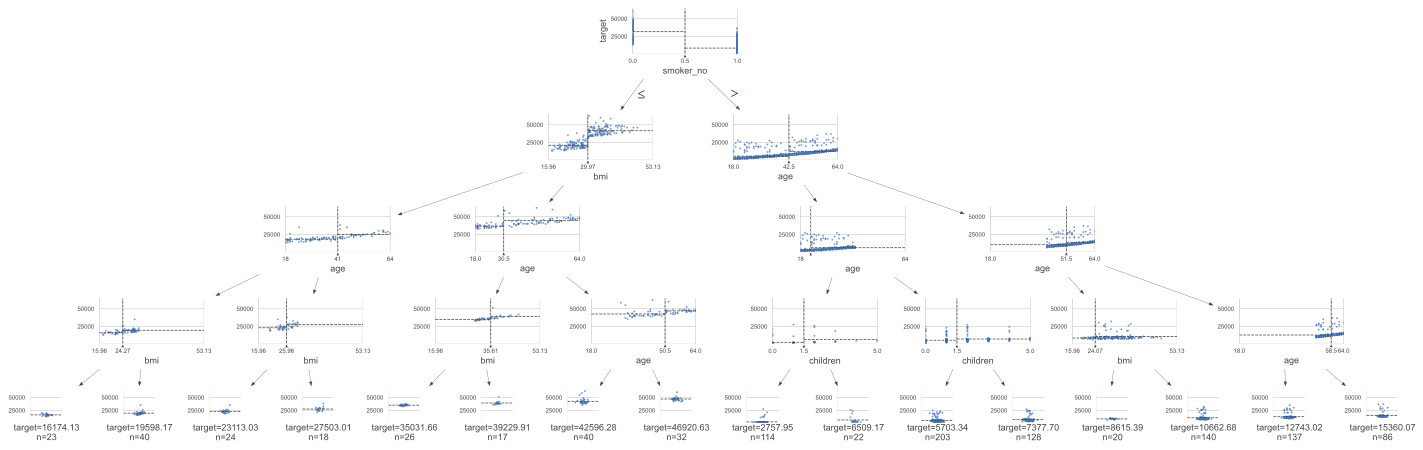

In [67]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(regressor, x_train, y_train,
                target_name="target",
                feature_names=x_train.columns)
viz

In [68]:
viz.save("decision_tree.svg")

In [69]:
#Comparação dos resultados no MSE
print(f'MSE do método dos Mínimos Quadrados: {mean_squared_error(y_test, resultado)}')
print(f'MSE do método dos Gradiente Descendente: {mean_squared_error(y_test, resultado_sgd)}')
print(f'MSE do método Árvore de Regressão: {mean_squared_error(y_test, resultado_arvore)}')

MSE do método dos Mínimos Quadrados: 33596915.851361476
MSE do método dos Gradiente Descendente: 47435278.07478512
MSE do método Árvore de Regressão: 21093484.004597444


In [70]:
#Aplicação do 3-Fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=3,random_state=42,shuffle=True)

scores = cross_val_score(DecisionTreeRegressor(random_state=42, max_depth=4),x_train,y_train,scoring='r2',cv=cv)

In [71]:
print("Scores:", scores)
print("Média:", scores.mean())
print("Desvio padrão:", scores.std())

Scores: [0.83589218 0.85226312 0.85683602]
Média: 0.8483304400533077
Desvio padrão: 0.00899113030151804


### Rede Neural com Scikit-Learn

In [72]:
from random import random
import re
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(12, 12), activation='relu',
 random_state=42, learning_rate='adaptive', alpha = 0.5, max_iter = 5000)
mlp.fit(x_train, y_train)

resultado_mlp = mlp.predict(x_test)

print('MSE, MAE E R2 COM MLP')
print(mean_squared_error(y_test, resultado_mlp))
print(mean_absolute_error(y_test, resultado_mlp))
print(r2_score(y_test, resultado_mlp))

MSE, MAE E R2 COM MLP
19726400.529710893
2654.7732497419975
0.8729368005769749


In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_escalado = scaler.fit_transform(x_train)
x_test_escalado = scaler.fit_transform(x_test)

In [74]:
from random import random
import re
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(12, 12), activation='relu',
 random_state=42, learning_rate='adaptive', alpha = 0, max_iter = 5000)
mlp.fit(x_train_escalado, y_train)

resultado_mlp_escalado = mlp.predict(x_test_escalado)

print('MSE, MAE E R2 COM MLP')
print(mean_squared_error(y_test, resultado_mlp_escalado))
print(mean_absolute_error(y_test, resultado_mlp_escalado))
print(r2_score(y_test, resultado_mlp_escalado))

MSE, MAE E R2 COM MLP
22196062.76397731
3013.0041682389146
0.8570290233569253


c:\users\pc gamer\appdata\local\programs\python\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Rede Neural com TensorFlow e Keras

In [83]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[11]), #x_train.shape
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(12, activation="relu"),
keras.layers.Dense(1)
])

#model = keras.models.Sequential([
#    keras.layers.Dense(50),
#    keras.layers.Dropout(0.25),
#    keras.layers.Dense(10),
#    keras.layers.Dropout(0.25),
#    keras.layers.Dense(1)
#])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 11)                0         
                                                                 
 dense_4 (Dense)             (None, 12)                144       
                                                                 
 dense_5 (Dense)             (None, 12)                156       
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 12)               

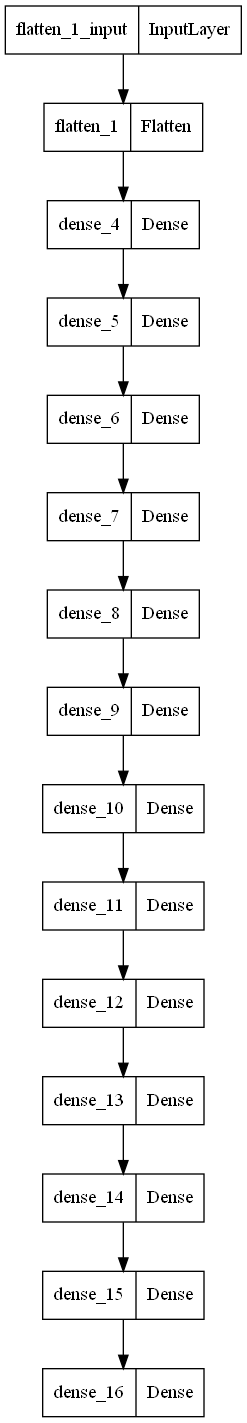

In [84]:
keras.utils.plot_model(model, to_file = "model.png")

In [85]:
#Depois de construir o modelo preciso compilar
#Na fase de compilação, define-se, por exemplo
#a função de perda, o otimizador, as métricas para serem calculadas  durante o treinamento e validação e etc

model.compile(loss="mae",
optimizer="adam")

In [86]:
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

Epoch 1/300
34/34 [==============================] - 2s 13ms/step - loss: 13345.0439 - val_loss: 12963.5586
Epoch 2/300
34/34 [==============================] - 0s 4ms/step - loss: 13303.6396 - val_loss: 12793.6104
Epoch 3/300
34/34 [==============================] - 0s 4ms/step - loss: 11936.1406 - val_loss: 8590.4180
Epoch 4/300
34/34 [==============================] - 0s 5ms/step - loss: 8055.5942 - val_loss: 8140.7725
Epoch 5/300
34/34 [==============================] - 0s 6ms/step - loss: 7855.2148 - val_loss: 7996.3789
Epoch 6/300
34/34 [==============================] - 0s 4ms/step - loss: 7702.1494 - val_loss: 7871.9292
Epoch 7/300
34/34 [==============================] - 0s 4ms/step - loss: 7628.5767 - val_loss: 7759.5371
Epoch 8/300
34/34 [==============================] - 0s 4ms/step - loss: 7542.1802 - val_loss: 7655.0645
Epoch 9/300
34/34 [==============================] - 0s 5ms/step - loss: 7455.8970 - val_loss: 7553.3525
Epoch 10/300
34/34 [=============================

In [87]:
resultado_mlp2 = model.predict(x_test)

print('MSE, MAE E R2 COM MLP')
print(mean_squared_error(y_test, resultado_mlp2))
print(mean_absolute_error(y_test, resultado_mlp2))
print(r2_score(y_test, resultado_mlp2))

9/9 [==============================] - 0s 2ms/step
MSE, MAE E R2 COM MLP
20101916.699230153
1525.6090862442281
0.8705179971129404


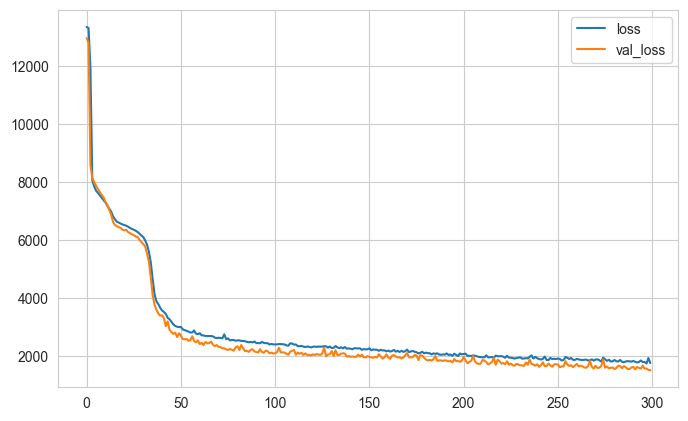

In [88]:
#Posso fazer curvas de aprendizado com o histórico do treinamento da rede neural
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()